## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import LabelEncoder

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

/var/folders/7z/lsvtctdd3pz4fhtvppypnv9c0000gp/T/ipykernel_68043/3197930731.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Loading Dataset 2

### Load and show the head of `ds2`

In [2]:
ds2 = pd.read_csv('../dataset2.csv')
ds2.head()

,BlindedIDs,PATIENT_ID,Stratagene,DC_STUDY_ID,MICROARRAY,SITE,TESTTYPE,IN_DC_STUDY,GENDER,AGE_AT_DIAGNOSIS,RACE,ADJUVANT_CHEMO,ADJUVANT_RT,VITAL_STATUS,FIRST_PROGRESSION_OR_RELAPSE,MONTHS_TO_FIRST_PROGRESSION,MTHS_TO_LAST_CLINICAL_ASSESSMENT,MONTHS_TO_LAST_CONTACT_OR_DEATH,SMOKING_HISTORY,SURGICAL_MARGINS,PATHOLOGIC_N_STAGE,PATHOLOGIC_T_STAGE,MEDIAN_INTENSITY_UNNORMALIZED,PCT_ARRAY_OUTLIER,PCT_SINGLE_OUTLIER,WARNING,LABORATORY_BATCH,Histologic grade
0,None4TestSets,151.0,0,B-NCI_U133A_1L.CHP,NCI_U133A_1L,MSKCC,Test 1,1,Male,64.0,White(01),Yes,No,Dead,Yes,8.0,15,16,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",191.0,2.536,0.143,NaN,NaN,POORLY DIFFERENTIATED
1,None4TestSets,152.0,0,B-NCI_U133A_2L.CHP,NCI_U133A_2L,MSKCC,Test 1,1,Male,62.0,White(01),Yes,Yes,Alive,Yes,3.0,72,72,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",193.0,4.573,0.288,NaN,NaN,Moderate Differentiation
2,None4TestSets,153.0,0,B-NCI_U133A_3L.CHP,NCI_U133A_3L,MSKCC,Test 1,1,Female,70.0,White(01),No,No,Alive,No,NaN,47,47,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T1, ACCORDING TO AJCC CRITERIA",192.0,1.512,0.131,NaN,NaN,Moderate Differentiation
3,None4TestSets,154.0,0,B-NCI_U133A_4L.CHP,NCI_U133A_4L,MSKCC,Test 1,1,Male,67.0,White(01),No,Yes,Dead,Yes,50.0,52,52,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N2, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",192.0,1.252,0.074,NaN,NaN,POORLY DIFFERENTIATED
4,None4TestSets,155.0,0,B-NCI_U133A_5L.CHP,NCI_U133A_5L,MSKCC,Test 1,1,Female,56.0,White(01),Yes,No,Dead,Yes,14.0,28,39,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",193.0,1.894,0.142,NaN,NaN,POORLY DIFFERENTIATED


In [3]:
ds2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 28 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   BlindedIDs                        502 non-null    object 
 1   PATIENT_ID                        479 non-null    float64
 2   Stratagene                        505 non-null    int64  
 3   DC_STUDY_ID                       479 non-null    object 
 4   MICROARRAY                        505 non-null    object 
 5   SITE                              505 non-null    object 
 6   TESTTYPE                          505 non-null    object 
 7   IN_DC_STUDY                       505 non-null    int64  
 8   GENDER                            478 non-null    object 
 9   AGE_AT_DIAGNOSIS                  478 non-null    float64
 10  RACE                              478 non-null    object 
 11  ADJUVANT_CHEMO                    478 non-null    object 
 12  ADJUVANT

## 1. Create XGBoost run a simple subset of `ds2`

### Define the features and the target columns

In [4]:
features = ['AGE_AT_DIAGNOSIS', 'GENDER', 'SMOKING_HISTORY', 'Histologic grade']
target = 'VITAL_STATUS'

### Simple preprocessing

In [5]:
gender_encoder = LabelEncoder()
smoking_history_encoder = LabelEncoder()
histologic_grade_encoder = LabelEncoder()

In [6]:
ds2_try1 = ds2[features + [target]].dropna()  # Dropping rows with missing values in the copy
ds2_try1['GENDER'] = gender_encoder.fit_transform(ds2_try1['GENDER'])  # Encoding categorical data
ds2_try1['SMOKING_HISTORY'] = smoking_history_encoder.fit_transform(ds2_try1['SMOKING_HISTORY'])
ds2_try1['Histologic grade'] = histologic_grade_encoder.fit_transform(ds2_try1['Histologic grade'])
ds2_try1[target] = LabelEncoder().fit_transform(ds2_try1[target])

### Splitting the dataset, Fit the model and Predictions and evaluation

In [7]:
X = ds2_try1[features]
y = ds2_try1[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.46


In [8]:
from sklearn.metrics import confusion_matrix

# plot the confusion matrix as a dataframe
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, columns=['Predicted Negative', 'Predicted Positive'], index=['Actual Negative', 'Actual Positive'])
cm_df

,Predicted Negative,Predicted Positive
Actual Negative,17,27
Actual Positive,23,25


In [9]:
# print the accuracy, precision recall and f1 score of the model as a dataframe
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score

precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
accuracy = accuracy_score(y_test, y_pred)

pd.DataFrame({
    'Accuracy': [accuracy],
	'Precision': [precision],
	'Recall': [recall],
	'F1': [f1]
})

,Accuracy,Precision,Recall,F1
0,0.456522,0.480769,0.520833,0.5


AGE_AT_DIAGNOSIS: 0.2112
GENDER: 0.1650
SMOKING_HISTORY: 0.4040
Histologic grade: 0.2199


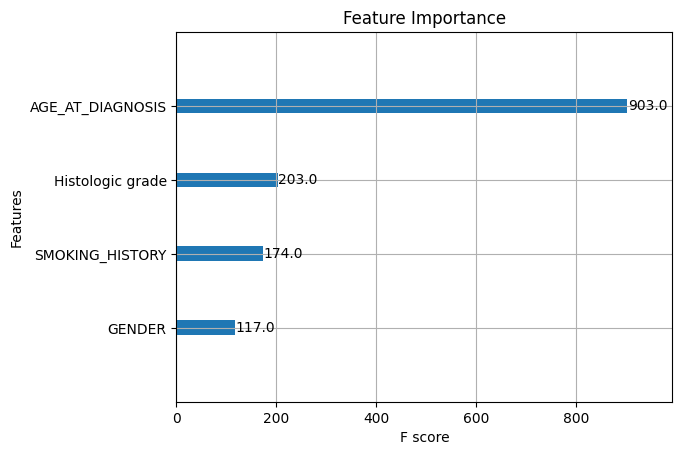

In [10]:
feature_importances = model.feature_importances_

# Print feature importances
for feature, importance in zip(features, feature_importances):
	print(f"{feature}: {importance:.4f}")

# Plot feature importances
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

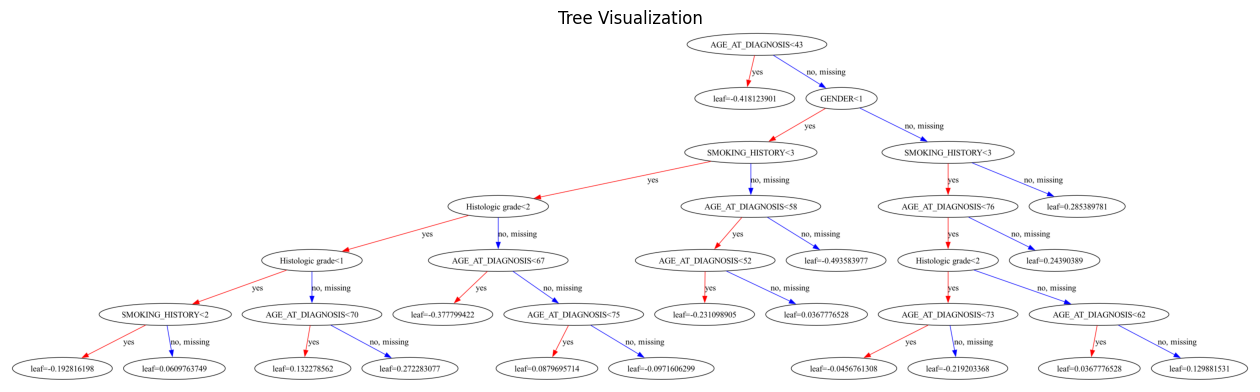

In [11]:
# Plot the first tree with improved quality
xgb.plot_tree(model, num_trees=0)
plt.title('Tree Visualization')

# Adjust figure size and DPI for higher quality
fig = plt.gcf()
fig.set_size_inches(16, 16)  # You can adjust the size as needed
plt.savefig('Trees Plots/tree_visualization_try1.png', dpi=300)  # Save the plot with higher DPI
plt.show()

## 2. Create a bit more complicated XGBoost run on `ds2`

### Drop columns that aren't vital

In [12]:
ds2_try2 = ds2.drop(columns=['PATIENT_ID', 'BlindedIDs', 'DC_STUDY_ID', 'MICROARRAY', 'WARNING', 'TESTTYPE'])
ds2_try2.head()

,Stratagene,SITE,IN_DC_STUDY,GENDER,AGE_AT_DIAGNOSIS,RACE,ADJUVANT_CHEMO,ADJUVANT_RT,VITAL_STATUS,FIRST_PROGRESSION_OR_RELAPSE,MONTHS_TO_FIRST_PROGRESSION,MTHS_TO_LAST_CLINICAL_ASSESSMENT,MONTHS_TO_LAST_CONTACT_OR_DEATH,SMOKING_HISTORY,SURGICAL_MARGINS,PATHOLOGIC_N_STAGE,PATHOLOGIC_T_STAGE,MEDIAN_INTENSITY_UNNORMALIZED,PCT_ARRAY_OUTLIER,PCT_SINGLE_OUTLIER,LABORATORY_BATCH,Histologic grade
0,0,MSKCC,1,Male,64.0,White(01),Yes,No,Dead,Yes,8.0,15,16,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",191.0,2.536,0.143,NaN,POORLY DIFFERENTIATED
1,0,MSKCC,1,Male,62.0,White(01),Yes,Yes,Alive,Yes,3.0,72,72,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",193.0,4.573,0.288,NaN,Moderate Differentiation
2,0,MSKCC,1,Female,70.0,White(01),No,No,Alive,No,NaN,47,47,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T1, ACCORDING TO AJCC CRITERIA",192.0,1.512,0.131,NaN,Moderate Differentiation
3,0,MSKCC,1,Male,67.0,White(01),No,Yes,Dead,Yes,50.0,52,52,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N2, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",192.0,1.252,0.074,NaN,POORLY DIFFERENTIATED
4,0,MSKCC,1,Female,56.0,White(01),Yes,No,Dead,Yes,14.0,28,39,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",193.0,1.894,0.142,NaN,POORLY DIFFERENTIATED


### Handling Boolean variables

In [13]:
filtered_columns = []
for column in ds2_try2.columns:
	unique_values = ds2_try2[column].unique()
	if len(unique_values) == 2 and 0 in unique_values and 1 in unique_values:
		filtered_columns.append(column)

ds2_try2[filtered_columns] = ds2_try2[filtered_columns].astype(bool)
booleans_df_try2 = ds2_try2[filtered_columns].copy()
booleans_df_try2.head()

,Stratagene,IN_DC_STUDY
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


### Spliting categorical and numerical dataframes

In [14]:
df_filter_booleans = ds2_try2.drop(columns=booleans_df_try2.columns)

categorical_df_try2 = df_filter_booleans.select_dtypes(include='object')
numerical_df_try2 = df_filter_booleans.select_dtypes(exclude='object')

In [15]:
numerical_df_try2.head()

,AGE_AT_DIAGNOSIS,MONTHS_TO_FIRST_PROGRESSION,MEDIAN_INTENSITY_UNNORMALIZED,PCT_ARRAY_OUTLIER,PCT_SINGLE_OUTLIER,LABORATORY_BATCH
0,64.0,8.0,191.0,2.536,0.143,NaN
1,62.0,3.0,193.0,4.573,0.288,NaN
2,70.0,NaN,192.0,1.512,0.131,NaN
3,67.0,50.0,192.0,1.252,0.074,NaN
4,56.0,14.0,193.0,1.894,0.142,NaN


### Searching numerical candidates to be categoric

Look like there are no numerical features that could be categorical

In [16]:
numeric_columns = numerical_df_try2.columns.to_list()

numeric_categoric_candidates = pd.DataFrame({
    'Minimum': ds2_try2[numeric_columns].min(numeric_only=True),
    'Maximum': ds2_try2[numeric_columns].max(numeric_only=True),
    'Count Unique': ds2_try2[numeric_columns].nunique(),
    'Is All Ints': ds2_try2[numeric_columns].apply(lambda x: x.dropna().apply(float.is_integer).all())
}).sort_values(by=['Is All Ints', 'Count Unique'], ascending=[False, True])

numeric_categoric_candidates

,Minimum,Maximum,Count Unique,Is All Ints
MEDIAN_INTENSITY_UNNORMALIZED,190.000,194.000,5,True
LABORATORY_BATCH,1.000,26.000,26,True
AGE_AT_DIAGNOSIS,33.000,87.000,50,True
MONTHS_TO_FIRST_PROGRESSION,0.460,102.000,112,False
PCT_SINGLE_OUTLIER,0.052,1.787,320,False
PCT_ARRAY_OUTLIER,0.494,21.649,378,False


### Searching categorical candidates to be booleans

looks like in the categorical_df_try2 there are Yes and No values in some of the columns

In [17]:
categorical_df_try2.head()

,SITE,GENDER,RACE,ADJUVANT_CHEMO,ADJUVANT_RT,VITAL_STATUS,FIRST_PROGRESSION_OR_RELAPSE,MTHS_TO_LAST_CLINICAL_ASSESSMENT,MONTHS_TO_LAST_CONTACT_OR_DEATH,SMOKING_HISTORY,SURGICAL_MARGINS,PATHOLOGIC_N_STAGE,PATHOLOGIC_T_STAGE,Histologic grade
0,MSKCC,Male,White(01),Yes,No,Dead,Yes,15,16,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",POORLY DIFFERENTIATED
1,MSKCC,Male,White(01),Yes,Yes,Alive,Yes,72,72,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",Moderate Differentiation
2,MSKCC,Female,White(01),No,No,Alive,No,47,47,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T1, ACCORDING TO AJCC CRITERIA",Moderate Differentiation
3,MSKCC,Male,White(01),No,Yes,Dead,Yes,52,52,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N2, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",POORLY DIFFERENTIATED
4,MSKCC,Female,White(01),Yes,No,Dead,Yes,28,39,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",POORLY DIFFERENTIATED


Looks like the categorical columns that are cadidates to be boolean can't be booleans.

This is because some of the categorical values are missing.

In [18]:
yes_no_columns = []
for column in categorical_df_try2.columns:
    unique_values = categorical_df_try2[column].unique()
    if len(unique_values) == 2 and "Yes" in unique_values or "No" in unique_values:
        yes_no_columns.append(column)

# Using the yes_no_columns list replace the values in the ds2_try2 Yes to 1 and the values No to 0.
# Join the yes_no_columns dataframe to the booleans_df_try2 dataframe, only if i haven't done it yet.
# And then turn the ds2_try2 dtypes of these columns to be bool

for column in yes_no_columns:
	ds2_try2[column] = ds2_try2[column].replace({"Yes": 1, "No": 0})
	if column not in booleans_df_try2.columns:
		booleans_df_try2[column] = ds2_try2[column]

ds2_try2[yes_no_columns].isnull().sum().to_frame("Missing Values")

,Missing Values
ADJUVANT_CHEMO,27
ADJUVANT_RT,27
FIRST_PROGRESSION_OR_RELAPSE,102


Looks like the column `MTHS_TO_LAST_CLINICAL_ASSESSMENT` isn't categorical but float, although its string

In [19]:
cols_unique = { }
for col in categorical_df_try2.columns:
	cols_unique[col] = categorical_df_try2[col].unique()

cols_unique

{'SITE': array(['MSKCC', 'DFCI', 'MI', 'HLM'], dtype=object),
 'GENDER': array(['Male', 'Female', nan], dtype=object),
 'RACE': array(['White(01)', 'Black or African American(03)', 'Asian(05)',
        'Unknown(99)', 'Native Hawaiian or Other Pacific Islander(04)',
        'Not Reported(98)', nan], dtype=object),
 'ADJUVANT_CHEMO': array(['Yes', 'No', 'Unknown', nan], dtype=object),
 'ADJUVANT_RT': array(['No', 'Yes', 'Unknown', nan], dtype=object),
 'VITAL_STATUS': array(['Dead', 'Alive', nan], dtype=object),
 'FIRST_PROGRESSION_OR_RELAPSE': array(['Yes', 'No', nan, 'Unknown'], dtype=object),
 'MTHS_TO_LAST_CLINICAL_ASSESSMENT': array(['15', '72', '47', '52', '28', '66', '44', '70', '74', '92', '65',
        '43', '4', '33', '21', '26', '73', '2', '8', '85', '91', '67',
        '24', '62', '114', '20', '50', '93', '51', '12', '37', '32', '31',
        '60', '13', '54', '38', '90', '34', '17', '80', '22', '63', '68',
        '7', '36', '19', '41', '42', '46', '55', '78', '48', '29', '1

Make the column `MTHS_TO_LAST_CLINICAL_ASSESSMENT` from string to be Categorical Ordered by its converted float value

In [20]:
ds2_try2['MTHS_TO_LAST_CLINICAL_ASSESSMENT'] = pd.to_numeric(ds2_try2['MTHS_TO_LAST_CLINICAL_ASSESSMENT'], errors='coerce').sort_values(ascending=True)
ds2_try2['MTHS_TO_LAST_CLINICAL_ASSESSMENT'] = pd.Categorical(ds2_try2['MTHS_TO_LAST_CLINICAL_ASSESSMENT'], ordered=True)


ds2_try2['MONTHS_TO_LAST_CONTACT_OR_DEATH'] = pd.to_numeric(ds2_try2['MONTHS_TO_LAST_CONTACT_OR_DEATH'], errors='coerce').sort_values(ascending=True)
ds2_try2['MONTHS_TO_LAST_CONTACT_OR_DEATH'] = pd.Categorical(ds2_try2['MONTHS_TO_LAST_CONTACT_OR_DEATH'], ordered=True)
ds2_try2[['MTHS_TO_LAST_CLINICAL_ASSESSMENT', 'MONTHS_TO_LAST_CONTACT_OR_DEATH']]

,MTHS_TO_LAST_CLINICAL_ASSESSMENT,MONTHS_TO_LAST_CONTACT_OR_DEATH
0,15.0,16.0
1,72.0,72.0
2,47.0,47.0
3,52.0,52.0
4,28.0,39.0
...,...,...
500,NaN,NaN
501,NaN,NaN
502,NaN,NaN
503,NaN,NaN


### Modify categorical dtype in `ds2_try2` to be category

In [21]:
ds2_try2[categorical_df_try2.columns] = ds2_try2[categorical_df_try2.columns].astype('category')

In [22]:
ds2_try2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype   
---  ------                            --------------  -----   
 0   Stratagene                        505 non-null    bool    
 1   SITE                              505 non-null    category
 2   IN_DC_STUDY                       505 non-null    bool    
 3   GENDER                            478 non-null    category
 4   AGE_AT_DIAGNOSIS                  478 non-null    float64 
 5   RACE                              478 non-null    category
 6   ADJUVANT_CHEMO                    478 non-null    category
 7   ADJUVANT_RT                       478 non-null    category
 8   VITAL_STATUS                      478 non-null    category
 9   FIRST_PROGRESSION_OR_RELAPSE      403 non-null    category
 10  MONTHS_TO_FIRST_PROGRESSION       188 non-null    float64 
 11  MTHS_TO_LAST_CLINICAL_ASSESSMENT  459 non-null    category

In [23]:
ds2_try2_numeric = ds2_try2.select_dtypes(include=['float64', 'int64'])
ds2_try2_category = ds2_try2.select_dtypes(include='category')
ds2_try2_bool = ds2_try2.select_dtypes(include=bool)

In [24]:
ds2_try2_numeric.head()

,AGE_AT_DIAGNOSIS,MONTHS_TO_FIRST_PROGRESSION,MEDIAN_INTENSITY_UNNORMALIZED,PCT_ARRAY_OUTLIER,PCT_SINGLE_OUTLIER,LABORATORY_BATCH
0,64.0,8.0,191.0,2.536,0.143,NaN
1,62.0,3.0,193.0,4.573,0.288,NaN
2,70.0,NaN,192.0,1.512,0.131,NaN
3,67.0,50.0,192.0,1.252,0.074,NaN
4,56.0,14.0,193.0,1.894,0.142,NaN


In [25]:
ds2_try2_category.head()

,SITE,GENDER,RACE,ADJUVANT_CHEMO,ADJUVANT_RT,VITAL_STATUS,FIRST_PROGRESSION_OR_RELAPSE,MTHS_TO_LAST_CLINICAL_ASSESSMENT,MONTHS_TO_LAST_CONTACT_OR_DEATH,SMOKING_HISTORY,SURGICAL_MARGINS,PATHOLOGIC_N_STAGE,PATHOLOGIC_T_STAGE,Histologic grade
0,MSKCC,Male,White(01),1,0,Dead,1,15.0,16.0,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",POORLY DIFFERENTIATED
1,MSKCC,Male,White(01),1,1,Alive,1,72.0,72.0,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",Moderate Differentiation
2,MSKCC,Female,White(01),0,0,Alive,0,47.0,47.0,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T1, ACCORDING TO AJCC CRITERIA",Moderate Differentiation
3,MSKCC,Male,White(01),0,1,Dead,1,52.0,52.0,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N2, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",POORLY DIFFERENTIATED
4,MSKCC,Female,White(01),1,0,Dead,1,28.0,39.0,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",POORLY DIFFERENTIATED


In [26]:
ds2_try2_bool.head()

,Stratagene,IN_DC_STUDY
0,False,True
1,False,True
2,False,True
3,False,True
4,False,True


### Machine Learning

- `ds2_try2` - the dataframe before preprocessing
- `ds2_try2_numeric` - dataframe with ds2_try2 numeric columns
- `ds2_try2_category` - dataframe with ds2_try2 categoric columns
- `ds2_try2_bool` - dataframe with ds2_try2 boolean columns

In [27]:
ds2_try2_category[ds2_try2_category.columns].head()

,SITE,GENDER,RACE,ADJUVANT_CHEMO,ADJUVANT_RT,VITAL_STATUS,FIRST_PROGRESSION_OR_RELAPSE,MTHS_TO_LAST_CLINICAL_ASSESSMENT,MONTHS_TO_LAST_CONTACT_OR_DEATH,SMOKING_HISTORY,SURGICAL_MARGINS,PATHOLOGIC_N_STAGE,PATHOLOGIC_T_STAGE,Histologic grade
0,MSKCC,Male,White(01),1,0,Dead,1,15.0,16.0,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",POORLY DIFFERENTIATED
1,MSKCC,Male,White(01),1,1,Alive,1,72.0,72.0,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",Moderate Differentiation
2,MSKCC,Female,White(01),0,0,Alive,0,47.0,47.0,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N0, ACCORDING TO AJCC CRITERIA","T1, ACCORDING TO AJCC CRITERIA",Moderate Differentiation
3,MSKCC,Male,White(01),0,1,Dead,1,52.0,52.0,Smoked in the past,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N2, ACCORDING TO AJCC CRITERIA","T3, ACCORDING TO AJCC CRITERIA",POORLY DIFFERENTIATED
4,MSKCC,Female,White(01),1,0,Dead,1,28.0,39.0,Currently smoking,ALL MARGINS PATHOLOGICALLY NEGATIVE,"N1, ACCORDING TO AJCC CRITERIA","T2, ACCORDING TO AJCC CRITERIA",POORLY DIFFERENTIATED


In [28]:
numeric_transformer = Pipeline(
	steps=[
		('imputer', SimpleImputer(strategy='median')),
		('scaler', StandardScaler())
	]
)

categorical_transformer = Pipeline(
    steps=[
		('imputer', SimpleImputer(strategy='most_frequent')),
		('encoder', OneHotEncoder(handle_unknown='ignore'))
	]
)

ds2_try2_temp = ds2_try2.copy()

for col in ds2_try2_category.columns:
    if col in ds2_try2_temp.columns:
        ds2_try2_temp[col] = ds2_try2_temp[col].astype(str)
        ds2_try2_temp[col] = ds2_try2_temp[col].replace('nan', np.nan)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, ds2_try2_numeric.columns),
        ('cat', categorical_transformer, ds2_try2_category.columns),
        ('bool', 'passthrough', ds2_try2_bool.columns)
    ]
)

vital_status_encoder = LabelEncoder()
ds2_try2_temp['VITAL_STATUS'] = vital_status_encoder.fit_transform(ds2_try2_category['VITAL_STATUS'])

X = preprocessor.fit_transform(ds2_try2_temp)
y = ds2_try2_temp['VITAL_STATUS']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 1.00


In [31]:
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
import pandas as pd

# Assuming y_test and y_pred are defined elsewhere in your code
precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro')
accuracy = accuracy_score(y_test, y_pred)

results_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Precision': [precision],
    'Recall': [recall],
    'F1': [f1]
})

results_df

,Accuracy,Precision,Recall,F1
0,1.0,1.0,1.0,1.0


AGE_AT_DIAGNOSIS: 0.0003
GENDER: 0.0000
SMOKING_HISTORY: 0.0000
Histologic grade: 0.0000


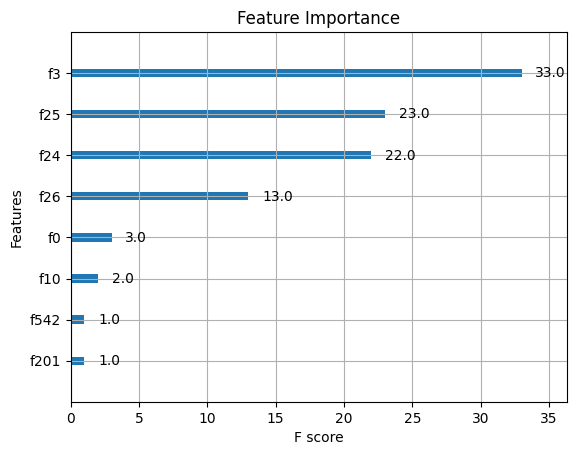

In [32]:
feature_importances = model.feature_importances_

# Print feature importances
for feature, importance in zip(features, feature_importances):
	print(f"{feature}: {importance:.4f}")

# Plot feature importances
xgb.plot_importance(model)
plt.title('Feature Importance')
plt.show()

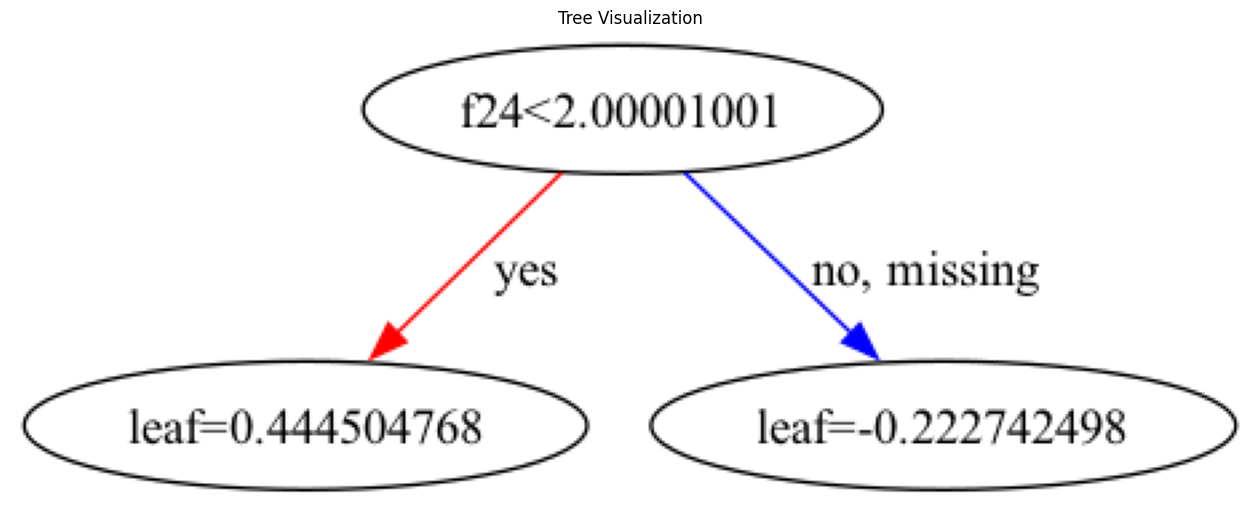

In [34]:
# Plot the first tree with improved quality
xgb.plot_tree(model, num_trees=0)
plt.title('Tree Visualization')

# Adjust figure size and DPI for higher quality
fig = plt.gcf()
fig.set_size_inches(16, 16)  # You can adjust the size as needed
plt.savefig('Trees Plots/tree_visualization_try2.png', dpi=300)  # Save the plot with higher DPI
plt.show()